# Embedding Model

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/customers_100k.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   account_id                       100000 non-null  object 
 1   country_name                     100000 non-null  object 
 2   account_category                 100000 non-null  object 
 3   bi_account_classification        100000 non-null  object 
 4   customer_type                    100000 non-null  object 
 5   region                           100000 non-null  object 
 6   sic_code                         100000 non-null  int64  
 7   employee_number                  100000 non-null  int64  
 8   revenue_in_eur                   100000 non-null  float64
 9   number_distinct_active_licenses  100000 non-null  int64  
 10  major_edition                    100000 non-null  object 
 11  total_connections_12m            100000 non-null  int64  
 12  tot

In [4]:
df.head(10)

,account_id,country_name,account_category,bi_account_classification,customer_type,region,sic_code,employee_number,revenue_in_eur,number_distinct_active_licenses,...,total_connections_12m,total_endpoints_12m,total_devices_12m,last_invoice_date_created,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,business_model
0,ac6a99474410f1c59c91da3f0cf9cf3f,Tonga,Standard,Inside Sales,Customer,APAC,7381,8,1502000.0,1,...,54,4,2,2023-11-23 01:57:47,Webshop,6,5,2532.84,466.47,S
1,1cc66628ed41f3db5a55195e93277a04,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,5049,11,1814000.0,1,...,3385,158,51,2023-10-07 19:35:11,Webshop,1,0,1298.15,972.57,S
2,db5f3cdd5629b9591b720b9b7e077df2,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,7389,16,13444000.0,1,...,12,2,2,2023-12-02 02:03:05,Webshop,2,1,155.83,76.69,S
3,bebb4028688f519f36ed220855b0a62f,Costa Rica,Standard,Reseller,End-User Reseller,AMERICAS,8711,36,7066000.0,3,...,1724,206,30,2023-10-25 23:32:46,Inside Sales,7,5,7550.16,1088.58,S
4,507c0bfb67895d773e3f8bd33b861d09,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,6531,312,61054000.0,2,...,6493,611,31,2023-11-17 04:16:51,Inside Sales,10,1,4688.33,1593.70,S
5,b1267a5b953b7267de811510f838172b,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,5943,25,4881000.0,1,...,583,3,5,2023-08-21 01:11:38,Webshop,5,4,971.96,198.63,S
6,3315ad169d4d2e9080f1377c44377c7c,Costa Rica,Standard,Reseller,Reseller,AMERICAS,7378,15,3013000.0,9,...,2181,311,7,2023-09-28 04:27:43,Reseller,7,15,66581.67,837.31,S
7,8ca7b69eda1a06b32e60fff1c6db3b28,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,1,717,159214000.0,1,...,2415,244,4,2023-12-22 06:27:18,Other,12,6,2986.48,211.88,S
8,5bd2eea4e2320b9246b41a8f54fb02d2,Costa Rica,SMB,Inside Sales,Customer,AMERICAS,8111,5,934000.0,3,...,22037,3766,1311,2023-09-22 01:48:17,Inside Sales,9,4,46022.86,9129.48,S
9,bbfb03bca60fb0185be3f36d12c99b3f,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,8731,22,4308000.0,2,...,4064,672,15,2023-12-20 01:21:26,Inside Sales,15,4,12584.99,1308.89,S


## Data Preprocessing

In [5]:
df.drop(columns=['business_model', 'last_invoice_date_created'], inplace=True)

In [6]:
# Define a dictionary to map SIC code ranges to major industry groups
major_groups = {
    range(1, 10): 'Agriculture, Forestry, and Fishing',
    range(10, 15): 'Mining',
    range(15, 18): 'Construction',
    range(20, 40): 'Manufacturing',
    range(40, 50): 'Transportation, Communications, Electric, Gas, and Sanitary Services',
    range(50, 52): 'Wholesale Trade',
    range(52, 60): 'Retail Trade',
    range(60, 68): 'Finance, Insurance, and Real Estate',
    range(70, 90): 'Services',
    range(90, 100): 'Public Administration'
}

# Map SIC code ranges to major industry group descriptions
def map_to_major_group(sic_code):
    for group_range, description in major_groups.items():
        if sic_code // 100 in group_range:
            return description
    return 'Unknown'

In [7]:
df['industry'] = df['sic_code'].apply(map_to_major_group)
df.drop(columns=['account_id','country_name','sic_code'], inplace=True)

In [8]:
df.head(10)

,account_category,bi_account_classification,customer_type,region,employee_number,revenue_in_eur,number_distinct_active_licenses,major_edition,total_connections_12m,total_endpoints_12m,total_devices_12m,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,industry
0,Standard,Inside Sales,Customer,APAC,8,1502000.0,1,Business,54,4,2,Webshop,6,5,2532.84,466.47,Services
1,Standard,Inside Sales,Customer,AMERICAS,11,1814000.0,1,Premium,3385,158,51,Webshop,1,0,1298.15,972.57,Wholesale Trade
2,Standard,Inside Sales,Customer,AMERICAS,16,13444000.0,1,Remote Access,12,2,2,Webshop,2,1,155.83,76.69,Services
3,Standard,Reseller,End-User Reseller,AMERICAS,36,7066000.0,3,Corporate,1724,206,30,Inside Sales,7,5,7550.16,1088.58,Services
4,Standard,Inside Sales,Customer,AMERICAS,312,61054000.0,2,Corporate,6493,611,31,Inside Sales,10,1,4688.33,1593.70,"Finance, Insurance, and Real Estate"
5,Standard,Inside Sales,Customer,AMERICAS,25,4881000.0,1,Remote Access,583,3,5,Webshop,5,4,971.96,198.63,Retail Trade
6,Standard,Reseller,Reseller,AMERICAS,15,3013000.0,9,Corporate,2181,311,7,Reseller,7,15,66581.67,837.31,Services
7,Standard,Inside Sales,Customer,AMERICAS,717,159214000.0,1,Business,2415,244,4,Other,12,6,2986.48,211.88,Unknown
8,SMB,Inside Sales,Customer,AMERICAS,5,934000.0,3,Corporate,22037,3766,1311,Inside Sales,9,4,46022.86,9129.48,Services
9,Standard,Inside Sales,Customer,AMERICAS,22,4308000.0,2,Corporate,4064,672,15,Inside Sales,15,4,12584.99,1308.89,Services


In [9]:
# Preprocess the data

# Separate numeric and categorical columns
cat_cols = ['account_category', 'bi_account_classification', 'customer_type', 
            'region', 'major_edition', 'current_sales_channel', 'industry']

num_cols = [col for col in df.columns if col not in cat_cols]

df_cols = num_cols + cat_cols

In [10]:
# Preprocess numeric data
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Preprocess categorical data
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [11]:
df.head(10)

,account_category,bi_account_classification,customer_type,region,employee_number,revenue_in_eur,number_distinct_active_licenses,major_edition,total_connections_12m,total_endpoints_12m,total_devices_12m,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,industry
0,4,1,0,1,0.000013,0.000003,0.000000,0,0.000046,0.000038,0.000076,5,0.294118,0.023585,0.001077,0.000670,7
1,4,1,0,0,0.000018,0.000004,0.000000,3,0.002967,0.002010,0.003819,5,0.000000,0.000000,0.000552,0.001398,10
2,4,1,0,0,0.000028,0.000030,0.000000,4,0.000010,0.000013,0.000076,5,0.058824,0.004717,0.000066,0.000109,7
3,4,4,1,0,0.000064,0.000016,0.012987,1,0.001511,0.002625,0.002215,0,0.352941,0.023585,0.003210,0.001565,7
4,4,1,0,0,0.000573,0.000139,0.006494,1,0.005692,0.007810,0.002291,0,0.529412,0.004717,0.001993,0.002292,2
5,4,1,0,0,0.000044,0.000011,0.000000,4,0.000510,0.000026,0.000306,5,0.235294,0.018868,0.000413,0.000284,6
6,4,4,3,0,0.000026,0.000007,0.051948,1,0.001912,0.003969,0.000458,4,0.352941,0.070755,0.028307,0.001204,7
7,4,1,0,0,0.001319,0.000361,0.000000,0,0.002117,0.003111,0.000229,3,0.647059,0.028302,0.001270,0.000304,9
8,3,1,0,0,0.000007,0.000002,0.012987,1,0.019322,0.048204,0.100053,0,0.470588,0.018868,0.019566,0.013138,7
9,4,1,0,0,0.000039,0.000010,0.006494,1,0.003563,0.008591,0.001069,0,0.823529,0.018868,0.005350,0.001882,7


In [12]:
# Extract features columns excluding 'account_id'
features_df = df

# Convert DataFrame to numpy array
features = features_df.to_numpy()

## Linear Embedding Model

In [13]:
class EmbeddingModel:
    def __init__(self, input_dim, embedding_dim, learning_rate=0.001, dropout_rate=0.2):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self._build_model()
    
    def _build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(128, activation='relu')(input_layer)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        embedding_layer = Dense(self.embedding_dim, activation='relu')(x)
        x = Dropout(self.dropout_rate)(embedding_layer)
        x = Dense(64, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        output_layer = Dense(self.input_dim, activation='linear')(x)

        # Create the MLP model
        self.encoder = Model(inputs=input_layer, outputs=output_layer)
        
        # Create a separate model for extracting embeddings
        self.embedding_model = Model(inputs=input_layer, outputs=embedding_layer)
        
        # Compile the MLP model
        self.encoder.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
    
    def train(self, data, epochs=100, batch_size=64, patience=10):
        early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            self.encoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping])
    
    def get_embeddings(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            return self.embedding_model.predict(data)
    
    def summary(self):
        print("Encoder Model Summary:")
        self.encoder.summary()
        print("\nEmbedding Model Summary:")
        self.embedding_model.summary()

In [14]:
# Initialize and train the autoencoder model
input_dim = features.shape[1]
embedding_dim = features.shape[1]  # Embedding dimension of 17 to make it easy to plot the resulting embeddings on a 2D scatter plot

In [15]:
# Initialize and train the encoder model
embedding_model = EmbeddingModel(input_dim=input_dim, embedding_dim=embedding_dim, dropout_rate=0.2)
embedding_model.summary()

Encoder Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense (Dense)               (None, 128)               2304      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 17)                1105      
                                                                 
 dropout_2 (Dropout)         (None, 17

In [16]:
embedding_model.train(features, epochs=100, batch_size=64, patience=10)

Epoch 1/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3367
Epoch 2/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1266
Epoch 3/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0982
Epoch 4/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0824
Epoch 5/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0749
Epoch 6/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0686
Epoch 7/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0645
Epoch 8/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0621
Epoch 9/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0591
Epoch 10/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0579
Epoch 11/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0563
Epoch 12/100
1563/1563 [==============================] - 5s 3ms/step - lo

In [17]:
embeddings = embedding_model.get_embeddings(features)

3125/3125 [==============================] - 2s 594us/step


## PCA

In [18]:
pca = PCA()
pca.fit(embeddings)

PCA()

In [19]:
print(pca.explained_variance_ratio_)

[4.18688358e-01 1.79095135e-01 1.49496387e-01 8.30123650e-02
 5.98235808e-02 4.86434506e-02 3.86647214e-02 1.34266547e-02
 5.40717214e-03 1.71283530e-03 1.06907179e-03 2.97729704e-04
 2.55385145e-04 1.81736347e-04 1.02385364e-04 7.64189273e-05
 4.66121938e-05]


Number of components explaining at least 80% variance: 4


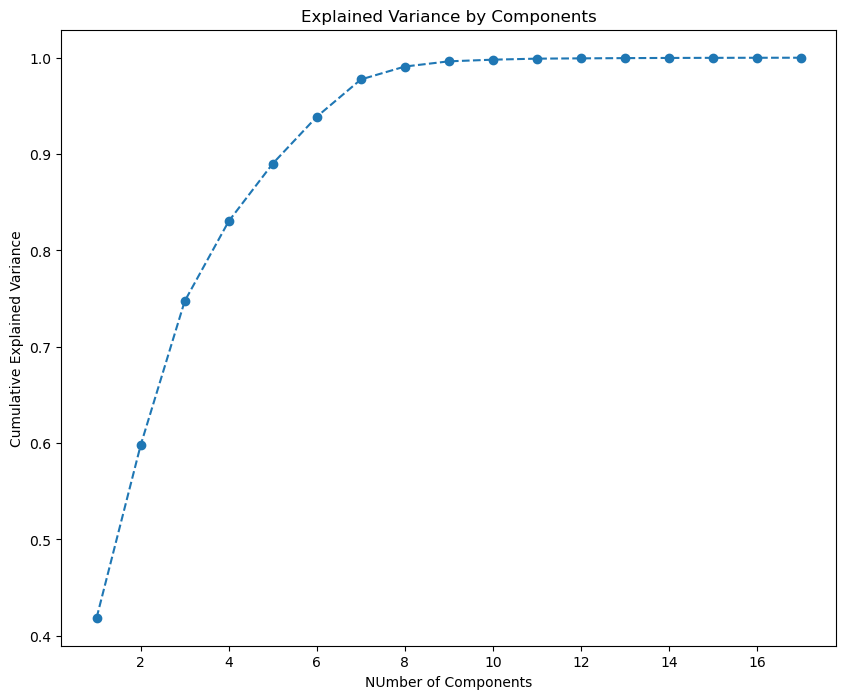

In [20]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize= (10, 8))
plt.plot(range(1,18), cumulative_explained_variance, marker = 'o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('NUmber of Components')
plt.ylabel('Cumulative Explained Variance')

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
print(f"Number of components explaining at least 80% variance: {n_components_80}")

In [21]:
pca = PCA(n_components=4)
features_pca = pca.fit_transform(embeddings)

## Determine the number of clusters(k)

In [22]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features_pca)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


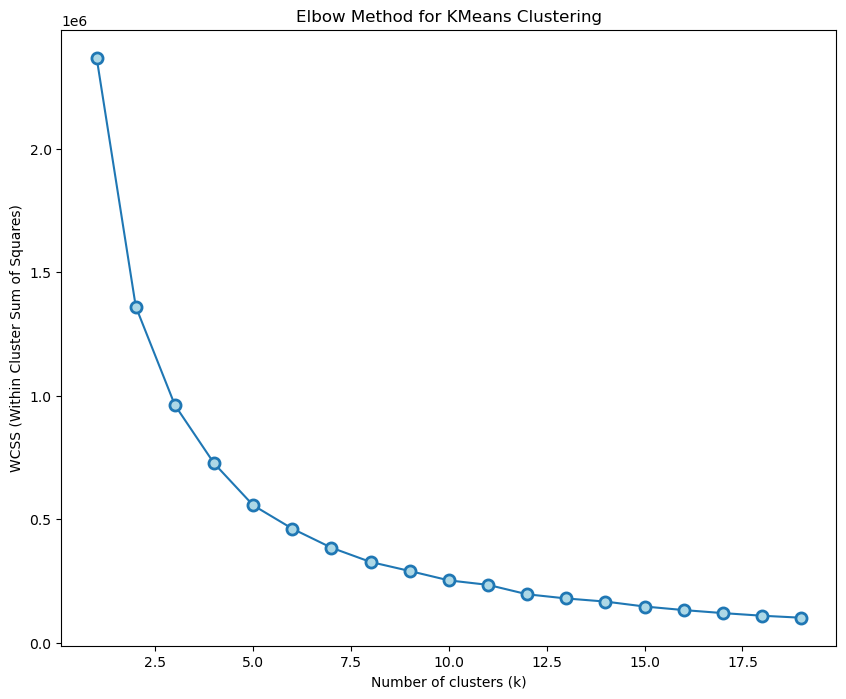

In [23]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [24]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=3, random_state=0).fit(features_pca)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(features_pca)], axis=1)
df_pca.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
df_pca['clusters'] = kmeans.labels_
df_pca['cluster_kmeans'] = kmeans.predict(features_pca)
df_latex = df_pca.groupby(['cluster_kmeans']).mean()
df_latex

,account_category,bi_account_classification,customer_type,region,employee_number,revenue_in_eur,number_distinct_active_licenses,major_edition,total_connections_12m,total_endpoints_12m,...,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,industry,0,Component 1,Component 2,Component 3,clusters
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,3.960755,1.154529,0.063452,1.631901,0.000507,0.000223,0.004607,0.934730,0.001568,0.002385,...,0.342075,0.018928,0.002321,0.001467,5.306426,-1.295256,-0.684147,-0.004373,-0.127196,0.0
1,3.949979,1.149638,0.064815,1.679225,0.000195,0.000143,0.005160,1.050766,0.001609,0.002584,...,0.364354,0.019545,0.002384,0.001453,9.968391,-0.628398,6.059120,-0.562847,1.393258,1.0
2,3.942824,1.111596,0.046077,1.440490,0.001025,0.000748,0.001017,4.076005,0.001844,0.002291,...,0.149164,0.010129,0.002246,0.002215,5.553770,8.139049,-0.297129,0.430633,-0.247142,2.0


In [25]:
df_latex.drop(columns=['Component 1', 'Component 2', 'Component 3', 'clusters'], inplace=True)
df_latex = df_latex.T

In [26]:
df_latex

cluster_kmeans,0,1,2
account_category,3.960755,3.949979,3.942824
bi_account_classification,1.154529,1.149638,1.111596
customer_type,0.063452,0.064815,0.046077
region,1.631901,1.679225,1.440490
employee_number,0.000507,0.000195,0.001025
revenue_in_eur,0.000223,0.000143,0.000748
number_distinct_active_licenses,0.004607,0.005160,0.001017
major_edition,0.934730,1.050766,4.076005
total_connections_12m,0.001568,0.001609,0.001844
total_endpoints_12m,0.002385,0.002584,0.002291


In [27]:
latex_table = df_latex.to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Average Values of each feature per Cluster",  # The caption to appear above the table in the LaTeX document
    label="tab:avg_clusters",  # A label used for referencing the table within the LaTeX document
    position="H",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="cccc",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.3f}".format  # Formats floats to two decimal places
)

print(latex_table)

\begin{table}[H]
\centering
\caption{Average Values of each feature per Cluster}
\label{tab:avg_clusters}
\begin{tabular}{cccc}
\toprule
     0 &      1 &     2 \\
\midrule
 3.961 &  3.950 & 3.943 \\
 1.155 &  1.150 & 1.112 \\
 0.063 &  0.065 & 0.046 \\
 1.632 &  1.679 & 1.440 \\
 0.001 &  0.000 & 0.001 \\
 0.000 &  0.000 & 0.001 \\
 0.005 &  0.005 & 0.001 \\
 0.935 &  1.051 & 4.076 \\
 0.002 &  0.002 & 0.002 \\
 0.002 &  0.003 & 0.002 \\
 0.002 &  0.001 & 0.002 \\
 2.522 &  2.354 & 3.863 \\
 0.342 &  0.364 & 0.149 \\
 0.019 &  0.020 & 0.010 \\
 0.002 &  0.002 & 0.002 \\
 0.001 &  0.001 & 0.002 \\
 5.306 &  9.968 & 5.554 \\
-1.295 & -0.628 & 8.139 \\
\bottomrule
\end{tabular}
\end{table}



In [28]:
df_pca.cluster_kmeans.value_counts()

0    77539
2    13065
1     9396
Name: cluster_kmeans, dtype: int64

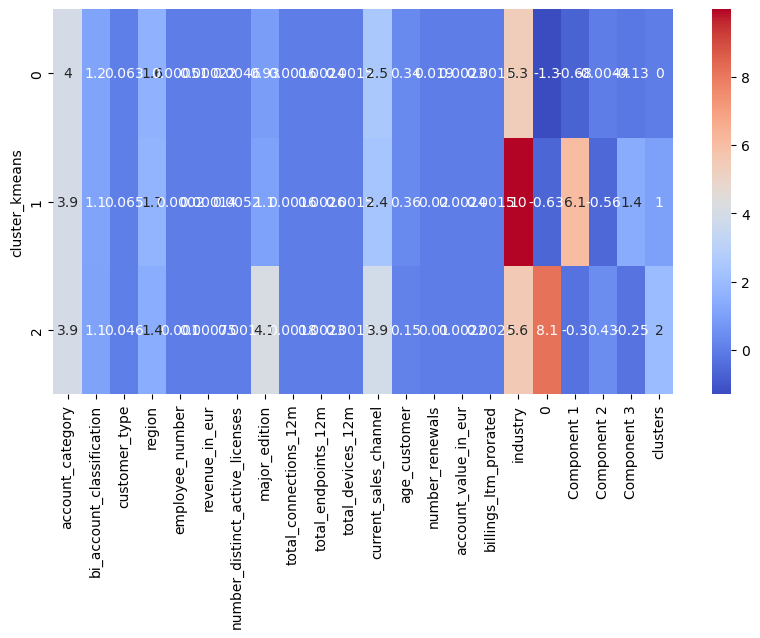

In [29]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df_pca.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [30]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", 
                    line_close=True,
                    height=800,
                    width=1200, 
                    title="AE Embedding Model Original Dataset Radar Chart")
fig.show()

In [31]:
clusters_df = clusters.groupby('label').size().reset_index()
clusters_df.rename(columns={'label': 'cluster', 0: 'count'}, inplace=True)
clusters_df

,cluster,count
0,0,77539
1,1,9396
2,2,13065


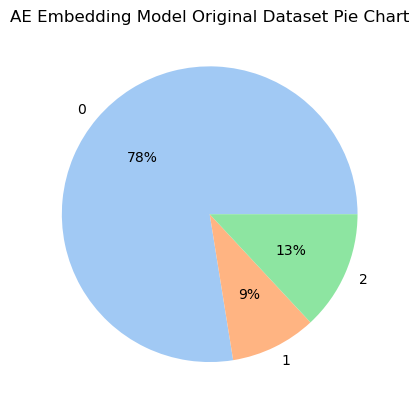

In [32]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(clusters_df['count'], labels = clusters_df['cluster'], colors = colors, autopct='%.0f%%')
plt.title('AE Embedding Model Original Dataset Pie Chart')
plt.show()

## Evaluation

In [33]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_pca, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.613


In [34]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(features_pca, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 0.756
